In [1]:
import os, sys
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely import wkt
import pickle
%matplotlib inline


/usr/local/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Reading Data

In [2]:
geometries_gdf = gpd.read_file("./data_for_test/geometries.shx")
econ_index = pd.read_json("./data_for_test/economy_index.json").transpose()
econ_index_points = [Point(longlat) for longlat in econ_index.longlat]
econ_index_gdf = gpd.GeoDataFrame(data=econ_index, geometry=econ_index_points,crs=geometries_gdf.crs.to_string())

rainfall_index = pd.read_json("./data_for_test/rainfall.json").transpose()
rainfall_index_geom = [wkt.loads(geom) for geom in rainfall_index.geometry.values]
rainfall_index_gdf = gpd.GeoDataFrame(data=rainfall_index.drop(columns=["geometry"]), geometry=rainfall_index_geom,crs=geometries_gdf.crs.to_string())

conflict_df = pd.read_json("./data_for_test/conflict.json").transpose()
food_df = pd.read_csv("./data_for_test/food_security.csv")

# Plot Geometries

<AxesSubplot:>

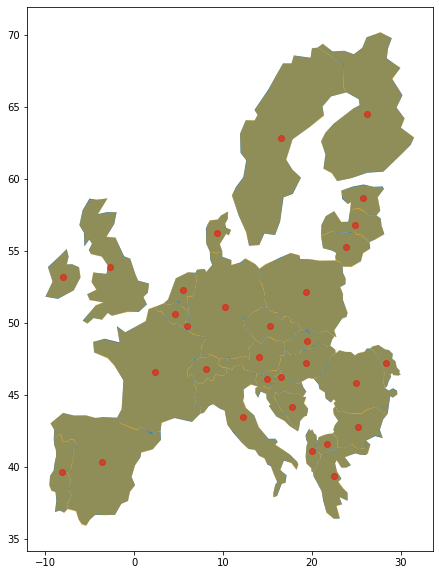

In [3]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
geometries_gdf.plot(ax=ax)
rainfall_index_gdf.plot(ax=ax, color="orange", alpha=0.5)
econ_index_gdf.plot(ax=ax, color="red", alpha=0.5)

# Matching

In [4]:
#This is an easy match, points must lie within the country
final_gdf = geometries_gdf.sjoin(econ_index_gdf, how="left", predicate="intersects").drop(columns=["index_right"])

In [5]:
#in this case we should look with the geometries with maximum overlap. Turns out they are ordered correctly. Indexes are meaningless
overlaps = [final_gdf.geometry.apply(lambda geom:geom.intersection(geom_int).area).argmax() for geom_int in rainfall_index_gdf.geometry.values]
print(overlaps)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [6]:
final_gdf["rainfall_mm"] = rainfall_index["rainfall_mm"].values

#conflict and food have no info but index, we hope they are ordered correctly
final_gdf["conflict_index"] = conflict_df["conflict_index"].values

def add_food_data(index):
    try: 
        return list(food_df["{}".format(index)].values)
    except KeyError:
        return [None for i in range(732)]
final_gdf["food_sec_index"] = [add_food_data(index) for index in final_gdf.index.values]

In [7]:
pickle.dump(final_gdf, open("./data_out/source_of_truth.pkl","wb"))

In [8]:
final_gdf.head()

,name,geometry,timestamps,longlat,country_index,rainfall_mm,conflict_index,food_sec_index
0,0,"POLYGON ((6.18632 49.46380, 6.65823 49.20196, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2.339088646029322, 46.60646337286316]","[52.070614423569296, 52.35771600662421, 52.232...","[395.61035643864466, 442.7231522964596, 425.45...","[0.050505050505050005, 0.040404040404040005, 0...","[None, None, None, None, None, None, None, Non..."
1,1,"POLYGON ((11.02737 58.85615, 11.46827 59.43239...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[16.59626584684802, 62.811484968080336]","[52.46364376657851, 52.69085209309422, 52.5963...","[402.51418487087494, 363.5393622301558, 406.00...","[0.10101010101010101, 0.16161616161616102, 0.1...","[0.3799148209122085, 0.3376813395216557, 0.467..."
2,2,"POLYGON ((23.48413 53.91250, 23.52754 53.47012...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[19.31101430844868, 52.14826021933187]","[43.22030072459218, 42.33757572283142, 41.6600...","[324.1388758141909, 407.141494904022, 363.7524...","[0.27272727272727204, 0.35353535353535304, 0.3...","[0.2129201797390732, 0.2039446070387124, 0.147..."
3,3,"POLYGON ((16.97967 48.12350, 16.90375 47.71487...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[14.076158884337072, 47.6139487927463]","[55.239678766385026, 55.27238771923675, 54.506...","[417.6345277818349, 437.65554079775177, 436.52...","[0.14141414141414102, 0.13131313131313102, 0.1...","[None, None, None, None, None, None, None, Non..."
4,4,"POLYGON ((22.08561 48.42226, 22.64082 48.15024...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[19.357628627745918, 47.19995117195427]","[56.83547763805197, 57.18940518698663, 57.2177...","[358.4700059615758, 460.575463749425, 454.6394...","[0.23232323232323202, 0.21212121212121202, 0.2...","[0.3955773528830284, 0.5081933356693316, 0.478..."
